# GNN을 활용한 추천시스템

- 데이터를 확인
- 간단한 추천 시스템
- 추천 시스템 개선


In [1]:
%pip install pandas seaborn torch_geometric scikit-learn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached tzdata-2025.3-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached pyparsing-3.3.2-py3-none-any.whl.metadata (5.8 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached joblib-1.5.3-py3-none-any.whl.metadata (5.5 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.4.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached attrs-25.4.0-py3-none-any.whl.metadata (10 kB)
  Using cached idna-3.11-py3-none-any.whl.metadata (8.4 kB)
  Using cached urllib3-2.6.3-py3-none-any.whl.metadata (6.9 kB)
  Using cached certifi-2026.1.4-py3-none-any.whl.metadata (2.5 kB)
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   --------- ----

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [3]:
ratings = pd.read_csv("data/ml-latest-small/ratings.csv")
movies = pd.read_csv("data/ml-latest-small/movies.csv")

In [4]:
df = pd.merge(ratings, movies, on="movieId")
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [5]:
df['userId'].nunique(), df['movieId'].nunique()

(610, 9724)

In [6]:
B = nx.Graph()

In [7]:
df["user_node"] = df["userId"].apply(lambda x: f'u_{x}')
df["movie_node"] = df["movieId"].apply(lambda x: f'm_{x}')
edges = list(zip(df["user_node"], df["movie_node"]))
B.add_edges_from(edges)

In [8]:
# 양쪽으로 나눠져야 함
is_bipartite = nx.is_bipartite(B)
degrees = dict(B.degree())
sorted_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
sorted_degrees[0:10]

[('u_414', 2698),
 ('u_599', 2478),
 ('u_474', 2108),
 ('u_448', 1864),
 ('u_274', 1346),
 ('u_610', 1302),
 ('u_68', 1260),
 ('u_380', 1218),
 ('u_606', 1115),
 ('u_288', 1055)]

In [9]:
top_users = [x for x in sorted_degrees if x[0].startswith("u_")][:5]
top_movies = [x for x in sorted_degrees if x[0].startswith("m_")][:5]

In [10]:
top_user_node = top_users[0][0]
neighbors = list(B.neighbors(top_user_node))

In [11]:
subset_movies = neighbors[:20]
subgraph_nodes = [top_user_node] + subset_movies
subgraph = B.subgraph(subgraph_nodes)

In [12]:
pos = nx.spring_layout(subgraph, seed=42)
colors = ['skyblue' if n.startswith("u_") else "lightgreen" for n in subgraph.nodes()]

### 추천 시스템

- 콘텐츠 기반 추천: 사용자가 과거에 좋아한 아이템의 속성과 유사한 것을 추천
- 협업 필터링: 사용자와 비슷한 사람들이 좋아한 것을 추천
- 순위 기반 추천: 전체 사용자가 가장 좋아하는 것(top 5)을 추천

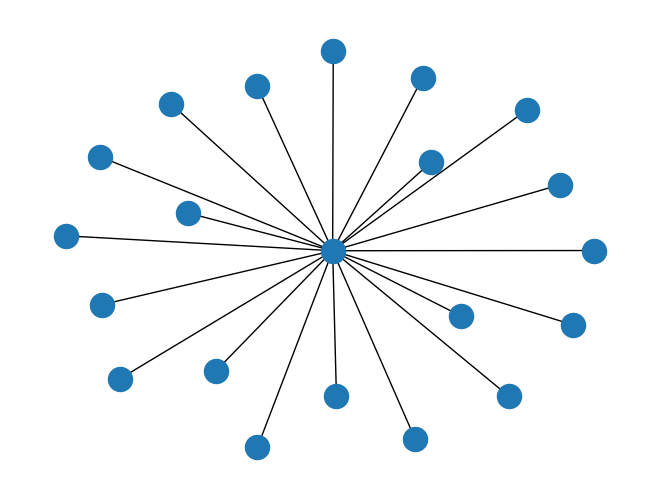

In [13]:
nx.draw(subgraph
        )

# GNN 기반 추천 시스템

- 최신 신경망 그래프 "LightGCN"
    - Linear Graph Conv Network
    - 학습방법: BPR(Bayesian Personalized Rate, 베이지안 방식) Loss를 사용한 Feedback


- 데이터 불러오기

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import LGConv
from torch_geometric.utils import structured_negative_sampling
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [16]:
ratings = pd.read_csv("data/ml-latest-small/ratings.csv")
ratings = ratings[ratings["rating"] >= 3.5]

user_ids = ratings["userId"].unique()
movie_ids = ratings["movieId"].unique()

user_map = {u : i for i, u in enumerate(user_ids)}
movie_map = {m : i for i, m in enumerate(movie_ids)}
ratings["userId"] = ratings["userId"].map(user_map)
ratings["movieId"] = ratings["movieId"].map(movie_map)

num_users = len(user_ids)
num_movies = len(movie_ids)


In [ ]:
class LightGCN(nn.Module):
    # 모든 init은 계산을 하지 않음 -> 빌딩 블록을 가지고 와야 함 -> 초기화를 반드시 해야 함
    # 데이터를 가장 먼저 학습 -> 최소한의 매개변수만 가질 수 있도록 노력
    def __init__(self, num_users, num_items, embedding_dim=64, num_layers=3):
        super().__init__(self, LightGCN)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(num_users + num_items, embedding_dim)
        nn.init.normal_(self.embedding.weight, std=0.1)

        self.convs = nn.ModuleList([LGConv() for _ in range(num_layers)])

    # 실제 학습
    # x에 무엇이 들어가야 하는가? x: edge_index
    def forward(self, x):
        emb = self.embedding.weight
        embs = [emb]

        for conv in self.convs:
            emb = conv(emb, x)
            embs.append(emb) # 4계층

        embs = torch.stack(embs, dim=1) # flatten
        embs_mean = torch.mean(embs, dim=1) # 평균
        return embs_mean
    
    def encode_minibatch(self, users, pos_items, neg_items, x):
        all_embs = self(x)
        user_embs = all_embs[users]
        pos_item_embs = all_embs[self.num_users + pos_items]
        neg_item_embs = all_embs[self.num_users + neg_items]
        return user_embs, pos_item_embs, neg_item_embs

    def get_loss(self,users, pos_items, neg_items, x):
        user_embs, pos_item_embs, neg_item_embs = self.encode_minibatch(users, pos_items, neg_items, x)
        pos_scores = torch.mul(user_embs, pos_item_embs).sum(dim=1)
        neg_scores = torch.mul(user_embs, neg_item_embs).sum(dim=1)
        loss = -torch.log(torch.sigmoid(pos_scores - neg_scores) + 1e-15).mean()
        
        return loss
